In [1]:
from scipy.stats import norm
import numpy as np
import sympy
import scipy
import torch
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
emc = float( sympy.S.EulerGamma.n(10) )
from tteVAMP.problem import *
from tteVAMP.denoisers import *
from tteVAMP.em import *
from tteVAMP.utils import plot_metrics
from tteVAMP.simulations import sim_model

EM VAMP loop

In [2]:
def infere(X, y, gam1, r1, tau1, p1, problem, maxiter, beta_true, update_mu, update_alpha):

    alpha = problem.prior_instance.distribution_parameters['alpha']
    mu = problem.prior_instance.distribution_parameters['mu'][0][0]

    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    x1_hats = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, problem)
        x1_hats.append(x1_hat)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, problem) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, problem)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        # z_hat = X@x1_hat
        # corr = np.dot(z_hat.transpose(), Xbeta_true) / np.linalg.norm(z_hat) / np.linalg.norm(Xbeta_true)
        # print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        # corrs_z.append(corr[0][0])
        # l2_err = np.linalg.norm(z_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        # print("l2 error for z1_hat = ", l2_err)
        # l2_errs_z.append(l2_err)
        ############################################################
        # Note: this correlation expression could be wrong!
        # corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        corr = np.corrcoef(np.squeeze(z1_hat, axis=-1), np.squeeze(Xbeta_true, axis=-1))
        print("corr(z1_hat, X*beta_true) = ", corr[0, 1])
        corrs_z.append(corr[0, 1])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, problem) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta_true-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        mu, alpha = update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it)
        problem.prior_instance.distribution_parameters['alpha'] = alpha
        problem.prior_instance.distribution_parameters['mu'] = np.full((y.shape[0],1), mu)

        
        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")


    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats, x1_hats

Experiments with synthetic genetic matrices X of varying sizes

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  2.9361235628007685
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.3722202522924425
gam2 =  2.5225561565998147


/Users/alexanders/vampW/tteVAMP/denoisers.py:100: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6915412287958037
l2 error for z1_hat =  0.8135482947197579
v1 =  0.034865534927765424
true tau2 =  6.942772700920337
tau2 = 2.768161931465571
->LMMSE
corr(x2_hat, beta_true) =  [[0.6009897]]
l2 error for x2_hat =  0.8344342138771821
alpha2 =  0.7233489312901739
true gam1 =  2.0886972482892916
gam1 =  0.9647734674317756
corr(z2_hat, beta_true) =  [[0.78540348]]
l2 error for z2_hat =  0.6858488214414524
true tau1 =  7.2894657102883675
tau1 =  7.237806758173005


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.09795812]
corr(x1_hat, beta_true) =  0.6358401090612219
l2 error for x1_hat =  0.831951160840684
B / (A+B) =  [0.36713011]
gam1 / (gam1 + 1/sigma) =  0.49103547224345656
alpha1 part I =  [0.18027391]
alpha2 part II =  [0.04531767]
alpha1 =  0.2151385856726094
true gam2 =  2.576395355056953
gam2 =  3.5196543929425372
corr(z1_hat, X*beta_true) =  0.7648801874613458
l2 error for z1_hat =  0.7060850277197146
v1 =  0.7973946280612754
true tau2 =  6

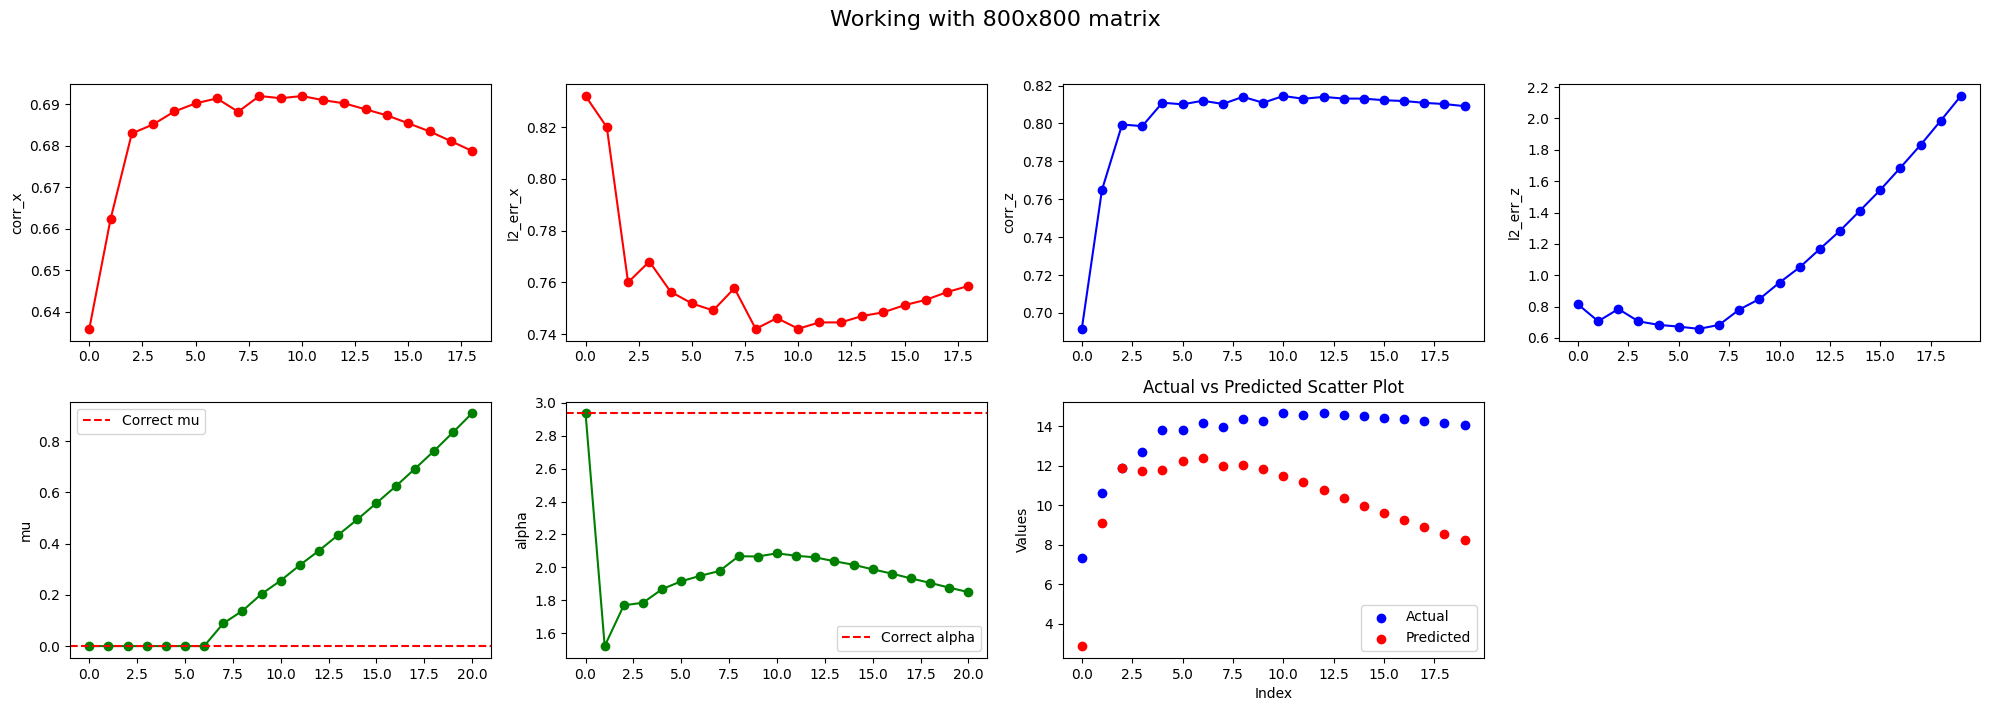

In [3]:
np.random.seed(42)
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 20

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats, x1_hats =  infere(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, True, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

In the definition of the for loop in vamp.py, we don't calculate empirical correlation. Instead, we calculate an alignment score. The variable naming corr is misleading, please disregard this

Below we show that the calculated alignment score is different from empirical correlation

In [12]:
corr1 = [np.corrcoef(np.squeeze(x1_hat, axis=-1), np.squeeze(beta, axis=-1))[0, 1]  for x1_hat in x1_hats]
corr1

[nan,
 0.6358040321379221,
 0.6626551157942381,
 0.6829507515577394,
 0.6851488245104617,
 0.6882564032523377,
 0.6901980745742802,
 0.6913782489785573,
 0.6883538789038459,
 0.6922544014954822,
 0.6919180787862078,
 0.6926799206706497,
 0.6919768461447261,
 0.691550726920298,
 0.6905502117234701,
 0.6896025830540119,
 0.6883456084388108,
 0.6871044758614979,
 0.6856488385945708,
 0.6842177898920232]

In [13]:
corr1 = [np.dot(np.squeeze(x1_hat, axis=-1), np.squeeze(beta, axis=-1)) / np.linalg.norm(x1_hat) / np.linalg.norm(beta) for x1_hat in x1_hats]
corr1

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_5354/2033597498.py:1: RuntimeWarning: invalid value encountered in scalar divide
  corr1 = [np.dot(np.squeeze(x1_hat, axis=-1), np.squeeze(beta, axis=-1)) / np.linalg.norm(x1_hat) / np.linalg.norm(beta) for x1_hat in x1_hats]


[nan,
 0.6358401090612219,
 0.6622803698145941,
 0.6829184956363319,
 0.6850985867426124,
 0.688215515317117,
 0.6901773933009746,
 0.6913616843012117,
 0.6881573666271659,
 0.6919520561882904,
 0.6914090069838786,
 0.6919459186606036,
 0.6909411985876911,
 0.690170956551734,
 0.6887221569861239,
 0.6872691940728468,
 0.6853750837435472,
 0.6834222092573599,
 0.6810889200469732,
 0.6786940013694237]

In [14]:
corr2 = [np.dot(np.squeeze(X@x1_hat, axis=-1), np.squeeze(X@beta, axis=-1)) / np.linalg.norm(X@x1_hat) / np.linalg.norm(X@beta) for x1_hat in x1_hats]
corr2

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_5354/4248809073.py:1: RuntimeWarning: invalid value encountered in scalar divide
  corr2 = [np.dot(np.squeeze(X@x1_hat, axis=-1), np.squeeze(X@beta, axis=-1)) / np.linalg.norm(X@x1_hat) / np.linalg.norm(X@beta) for x1_hat in x1_hats]


[nan,
 0.7957322357083159,
 0.5225028214926293,
 0.7599218156888145,
 0.7455338117172454,
 0.7555949584165627,
 0.7734499358998318,
 0.7777183297221921,
 0.6353844561907147,
 0.5669046144775224,
 0.4522451622424299,
 0.35872634337353365,
 0.265398393703615,
 0.1891176680496338,
 0.11795189722503235,
 0.060966145024705855,
 0.009370874111117389,
 -0.03218516519945824,
 -0.06966612033402012,
 -0.10003232547159328]

In [15]:
corr2 = [np.corrcoef(np.squeeze(X@x1_hat, axis=-1), np.squeeze(X@beta, axis=-1))[0, 1]  for x1_hat in x1_hats]
corr2

[nan,
 0.7644097579024745,
 0.7930353095306572,
 0.8071920331593816,
 0.8075978693275104,
 0.8110457373228762,
 0.8117776878503378,
 0.8127063754814989,
 0.8105354575119181,
 0.8137896576299483,
 0.8127993316194884,
 0.8140742818476193,
 0.8133737606930017,
 0.8133877010311129,
 0.8127102728134394,
 0.8122457032216569,
 0.8114495062667247,
 0.8107490549216413,
 0.8098139123311222,
 0.8089440908673878]